In [1]:
import warnings
warnings.filterwarnings("ignore")
import itertools
from datetime import datetime as dt
import locale
locale.setlocale(locale.LC_ALL, 'ru_RU')

import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
import ml_metrics as metrics

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 20, 5

In [2]:
import os
files = [os.path.join('data', item) for item in os.listdir(f'data')]
files

['data/Шахматка, скв. 5150    (01.03.2017 - 01.12.2019).xlsx',
 'data/Шахматка, скв. 4202    (01.08.2015 - 01.12.2019).xlsx',
 'data/Шахматка, скв. 1175    (01.01.1989 - 01.12.2019).xlsx',
 'data/Шахматка, скв. 2071    (01.01.1993 - 01.12.2019).xlsx',
 'data/Шахматка, скв. 1314    (01.05.1985 - 01.12.2019).xlsx',
 'data/Шахматка, скв. 5301    (01.01.1993 - 01.12.2019).xlsx',
 'data/Шахматка, скв. 4207    (01.01.1991 - 01.12.2019).xlsx']

In [3]:
class ItemLoader:
    
    def __init__(self, path):
        self.path = path
        self.data = pd.read_excel(path)
        self.columns = list(self.data['Unnamed: 4'][3:24])
        self.important_columns = list(list(self.columns[1:8]) + [self.columns[10]])
        
    def date_mask(self, full_idx):
        indexes = []
        for i in range(len(full_idx)):
            try:
                indexes.append(dt.strptime(full_idx[i], '%d %B %Y'))
            except ValueError:
                indexes.append(None)
        return indexes
        
    def time_idx(self):
        
        month_indexes = list(self.data[self.data.keys()[1]].iloc[[((i - 3) % 21 == 0) 
                                                                  for i in range(len(self.data.index))]])
        month_indexes = [m.split()[0] + 'а ' + m.split()[1] 
                         if m.split()[0][-1] == "т" 
                         else m.split()[0].replace(m.split()[0][-1], 'я ') + m.split()[1] 
                         for m in month_indexes][::-1]
        
        full_idx = [str(i) + ' ' + month for month in month_indexes for i in range(1, 32)]
        # заменяем нулями лишние даты (31 сентября)
        index_row = self.date_mask(full_idx)
        
        return index_row
        
        
    def collect_timeseries(self, key='Qн'):
        
        row = self.data.loc[self.data['Unnamed: 4'] == key].iloc[:,6:].values[::-1].flatten()
        idx = self.time_idx()
        return pd.Series(row, index=idx, name=key)
    
    def apply_idx(self, table):
        tab = table.loc[table.index.notnull()]
        tab = tab.reindex(pd.date_range(tab.index[0], freq='D', periods=tab.shape[0]))
        return tab
        
    def fill_nulls(self, table):
        return table.fillna(table.bfill())
    
    def show_plot(self, table, title='Features'):
        ax = table.plot(
            label=[key for key in table.keys()] if type(table) == pd.DataFrame else table.name, 
            figsize=(20, 5)
        )
        ax.set_xlabel('Date')
        ax.set_ylabel('Amount')
        plt.title(title + f' {self.path.split()[2]}')
        plt.legend()
        plt.grid(True)
        plt.show()


In [4]:
class StatModel:
    
    def __init__(self, subtable):
        self.subtable = subtable.dropna()
        
    def show_diff_order(self):
    
        fig = plot_pacffig = plt.figure(figsize=(20, 10))

        ax1 = fig.add_subplot(311)
        fig = plot_acf(self.subtable, ax=ax1,
                       title="Autocorrelation on Original Series") 

        ax2 = fig.add_subplot(312)
        fig = plot_acf(self.subtable.diff().dropna(), ax=ax2, 
                       title="1st Order Differencing")

        ax3 = fig.add_subplot(313)
        fig = plot_acf(self.subtable.diff().diff().dropna(), ax=ax3, 
                       title="2nd Order Differencing")
        
    def show_autocorr(self):
        fig = plot_pacffig = plt.figure(figsize=(20, 10))
        
        ax1 = fig.add_subplot(311)
        fig = plot_pacf(self.subtable.diff().dropna(), ax=ax1, lags=40)

        ax2 = fig.add_subplot(312)
        fig = plot_acf(self.subtable.diff().dropna(), ax=ax2, lags=40)
        
    def gen_arima_pdq(self, top):
        p = d = q = range(top + 1)
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = (0, 0, 0, 0) 
        
        best_params = None
        aic = None
        for param in pdq:
            try:
                mod = SARIMAX(
                    self.subtable,
                    order=param,
                    seasonal_order=seasonal_pdq,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
                results = mod.fit()
#                 print(param, results.aic)
                if aic:
                    if results.aic < aic:
                        best_params = param
                else:
                    best_params = param
                    aic = results.aic
                    
            except Exception as e:
                print(e)
                continue
        
        return best_params
    
    def get_sarimax_pdq(self, top):
        p = d = q = range(top + 1)
        pdq = list(itertools.product(p, d, q))
        seasonal_pdq = [(x[0], x[1], x[2], 4) 
                        for x in list(itertools.product(p, d, q))]
        
        best_params = None
        aic = None
        
        for param in pdq:
            for param_seasonal in seasonal_pdq:
                try:
                    mod = SARIMAX(
                        self.subtable,
                        order=param,
                        seasonal_order=param_seasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
                    results = mod.fit()
#                     print(param, results.aic)
                    if aic:
                        if results.aic < aic:
                            best_params = param, param_seasonal
                    else:
                        best_params = param, param_seasonal
                        aic = results.aic

                except Exception as e:
                    print(e)
                    continue

        return best_params
        
    def predict_manual_arima(self, pdq=(1, 1, 1)):
        
        model = ARIMA(self.subtable.fillna(self.subtable.bfill()), order=pdq)
        results = model.fit()
        
        actual_row = self.subtable[-32:]
        predicted_row = results.predict(start=self.subtable.index[-32], 
                                        end=self.subtable.index[-1], 
                                        typ='levels')
        
        r2 = r2_score(actual_row, predicted_row)
        rmse = metrics.rmse(actual_row, predicted_row)
        mae = metrics.mae(actual_row, predicted_row)
        
        fig, ax = plt.subplots()
        ax = self.subtable.plot(ax=ax, figsize=(20, 5))
        fig = results.plot_predict(self.subtable.shape[0], self.subtable.shape[0] + 183, 
                                   dynamic=True, ax=ax, plot_insample=False)

        plt.xlabel("Date")
        plt.ylabel('Oil debet')
        plt.legend(("Actual values", "Forecast", "95% confidence interval"),  
                   loc="upper left")
        plt.grid(True)
#         plt.ylim(ymin=-1)
        print(f'R^2: {r2}; RMSE: {rmse}; MAE: {mae}')
        plt.show()
        
        
    def predict_manual_sarimax(self, pdqPDQm=((1,1,1),(1,1,1,4))):
        table = self.subtable.resample(f'{pdqPDQm[1][-1]}D', how='mean')
        table = table.fillna(table.bfill())
        
        model = SARIMAX(table, order=pdqPDQm[0], seasonal_order=pdqPDQm[1])
        results = model.fit()
        
        actual_row = table[-round(32 / pdqPDQm[1][-1]):]
        predicted_row = results.predict(start=table.index[-round(32 / pdqPDQm[1][-1])], 
                                        end=table.index[-1], 
                                        typ='levels')
        
        r2 = r2_score(actual_row, predicted_row)
        rmse = metrics.rmse(actual_row, predicted_row)
        mae = metrics.mae(actual_row, predicted_row)
        
        forecast = results.forecast(table.index[-1] + round((365/2) / (pdqPDQm[1][-1])))
        
        fc_ind = pd.date_range(table.index[-1], 
                               periods=round((365/2) / (pdqPDQm[1][-1])), 
                               freq=f'{pdqPDQm[1][-1]}D')
        fc_series = pd.Series(forecast, index=fc_ind)
        
        predict = results.get_prediction(start=table.index[-1], 
                                         end=table.index[-1] + round((365/2)/(pdqPDQm[1][-1])))
        confint = predict.conf_int()
        lower_series = pd.Series(confint.iloc[:, 0], index=fc_ind)
        upper_series = pd.Series(confint.iloc[:, 1], index=fc_ind)
        
        
        fig, ax = plt.subplots()
        ax = table.plot(ax=ax, figsize=(20, 5))
        fig = fc_series.plot(ax=ax)
        plt.fill_between(lower_series.index, 
                         lower_series, 
                         upper_series, 
                         color="k", 
                         alpha=0.25)
        plt.xlabel("Date")
        plt.ylabel('Oil debet')
        plt.legend(("Actual values", "Forecast", "95% confidence interval"),  
                   loc="upper left")
        plt.grid(True)
#         plt.ylim(ymin=-1)
        
        print(f'R^2: {r2}; RMSE: {rmse}; MAE: {mae}')
        plt.show()
        
    
    def predict_auto_arima(self, silent=False):
        warnings.filterwarnings("ignore")
        automodel = pm.auto_arima(self.subtable, 
                              start_p=0, 
                              start_q=0,
                              test="adf",
                              seasonal=False,
                              trace=False) # log
        
        fc, confint = automodel.predict(n_periods=183, 
                                        return_conf_int=True)
        
        fc_ind = pd.date_range(self.subtable.index[-1], periods=183)
        
        actual_row = self.subtable[-32:]
        predicted_row = fc[-32:]
        
        r2 = r2_score(actual_row, predicted_row)
        rmse = metrics.rmse(actual_row, predicted_row)
        mae = metrics.mae(actual_row, predicted_row)
        
        fc_series = pd.Series(fc, index=fc_ind)
        lower_series = pd.Series(confint[:, 0], index=fc_ind)
        upper_series = pd.Series(confint[:, 1], index=fc_ind)
        
        if not silent:
            fig, ax = plt.subplots()
            ax = self.subtable.plot(ax=ax, figsize=(20, 5))
            fig = fc_series.plot(ax=ax)
            plt.fill_between(lower_series.index, 
                             lower_series, 
                             upper_series, 
                             color="k", 
                             alpha=0.25)
            plt.xlabel("Date")
            plt.ylabel(self.subtable.name)
            plt.legend(("Actual values", "Forecast", "95% confidence interval"),  
                       loc="upper left")
            plt.grid(True)
    #         plt.ylim(ymin=-1)
            print(f'R^2: {r2}; RMSE: {rmse}; MAE: {mae}')
            plt.show()
        
        return fc_series

In [5]:
class MLModel:
    
    def __init__(self, train_table, arima_pred_table):
        self.train_table = train_table
        self.arima_pred_table = arima_pred_table    
        self.valid = self.train_table.dropna(axis=0)
        self.pred = self.arima_pred_table.dropna(axis=0)
        
    def split_table(self, test_size=32):
        target_name = 'Qн'
        feature_names = [key for key in df.keys() if key != target_name]
        
        X_train = self.valid[feature_names][:-test_size]
        y_train = self.valid[target_name][:-test_size]
        
        X_test = self.valid[feature_names][-test_size:]
        y_test = self.valid[target_name][-test_size:]
        
        X_arima = self.pred[feature_names]
        y_arima = self.pred[target_name]
        
        return X_train, y_train, X_test, y_test, X_arima, y_arima
    
    def xgb_model(self, X, y):
        gsc = GridSearchCV(
            estimator=XGBRegressor(objective='reg:squarederror'),
            param_grid={
                'n_estimators': [10, 25, 50],
                'learning_rate': [0.03, 0.04, 0.05],
                'max_depth': [2, 3, 4],
            },
            verbose=0, n_jobs=-1)

        grid_result = gsc.fit(X, y)
#         print(grid_result.best_params_)
        best_params =  grid_result.best_params_

        xgb = XGBRegressor(
            n_estimators=best_params['n_estimators'], 
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            objective='reg:squarederror'
        )
    
        return xgb
    
    def gbr_model(self, X, y):
        gsc = GridSearchCV(
            estimator=GradientBoostingRegressor(),
            param_grid={
                'n_estimators': [10, 100, 500],
                'learning_rate': [0.02, 0.03, 0.04],
                'max_depth': [4, 5, 6],
            },
            verbose=0, n_jobs=-1)

        grid_result = gsc.fit(X, y)
#         print(grid_result.best_params_)
        best_params = grid_result.best_params_
    
        gbr = GradientBoostingRegressor(
            max_depth=best_params['max_depth'],
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
        )

        return gbr
    
    def rfr_model(self, X, y):
        gsc = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid={
                'n_estimators': [10, 100, 500],
                'max_depth': [2, 3],
            },
            verbose=0, n_jobs=-1)

        grid_result = gsc.fit(X, y)
#         print(grid_result.best_params_)
        best_params = grid_result.best_params_
    
        rfr = RandomForestRegressor(
            max_depth=best_params['max_depth'],
            n_estimators=best_params['n_estimators'],
        )

        return rfr
    
    def construct_cross_df(self, train, pred):
    
        cross_idx = train.index.append(pred.index).unique()
        cross_df = pd.DataFrame([], index=cross_idx)
        cross_df = cross_df.join(train).rename(columns={'Qн':'Actual Qн'})
        cross_df = cross_df.join(pred).rename(columns={'Qн':'Predicted Qн'})
        
        return cross_df
    
    def get_prediction(self, model, train_test_tuple):
        
        X_train, y_train, X_test, y_test, X_arima, y_arima = train_test_tuple
        model.fit(X_train, y_train)

        y_preds = pd.Series(model.predict(X_test), 
                                 index=y_test.index, name = 'Qн')

        actual_row = y_test
        predicted_row = y_preds
        r2 = r2_score(actual_row, predicted_row)
        rmse = metrics.rmse(actual_row, predicted_row)
        mae = metrics.mae(actual_row, predicted_row)
        print(f'R^2: {r2}; RMSE: {rmse}; MAE: {mae}')
    
        y_forecasted = pd.Series(model.predict(X_arima), 
                                 index=y_arima.index, name = 'Qн')
    
        cross_df = self.construct_cross_df(y_train.append(y_test), y_forecasted)
        
        return cross_df

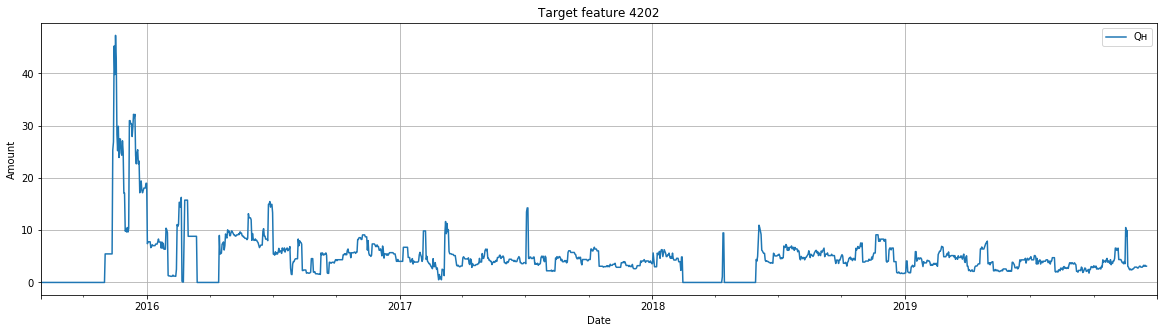

In [6]:
# Инициируем контейнер для обработки исходных данных
item = ItemLoader(files[1])

# Собираем данные по временным рядам
oil = item.collect_timeseries()

# Приводим индексы формату Datetime
oil = item.apply_idx(oil)

# Заполняем пробелы в данных
oil = item.fill_nulls(oil)

# Выводим график целевого параметра
item.show_plot(oil, title='Target feature')

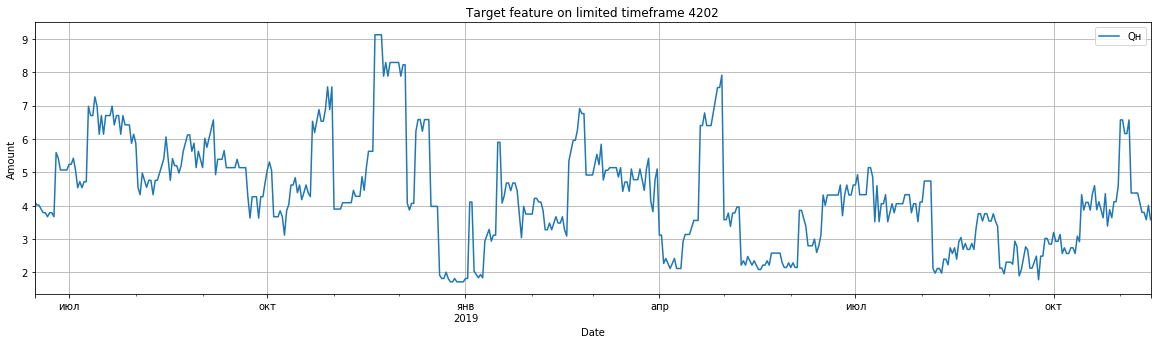

In [7]:
# Выбираем временной интервал со стабильным графиком функции
start = '2018-06-15'
end = '2019-11-15'
subtable = oil[start:end]
item.show_plot(subtable, title='Target feature on limited timeframe')

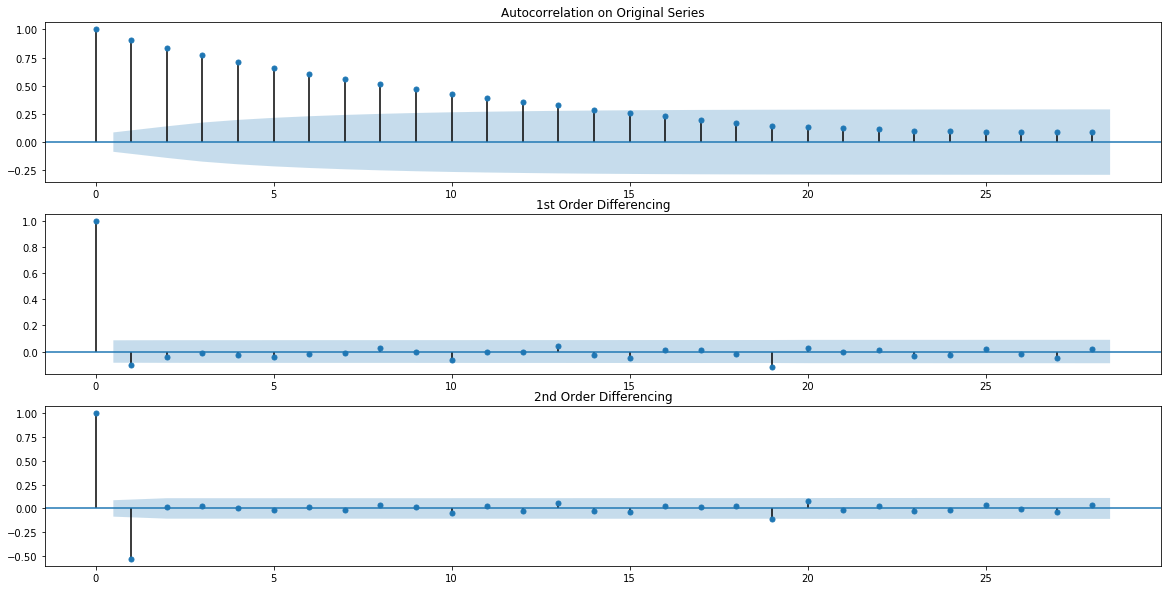

In [8]:
# Инициируем контейнер для обработки выборки моделями
model = StatModel(subtable)

# Определяем порядок дифференцирования
model.show_diff_order()

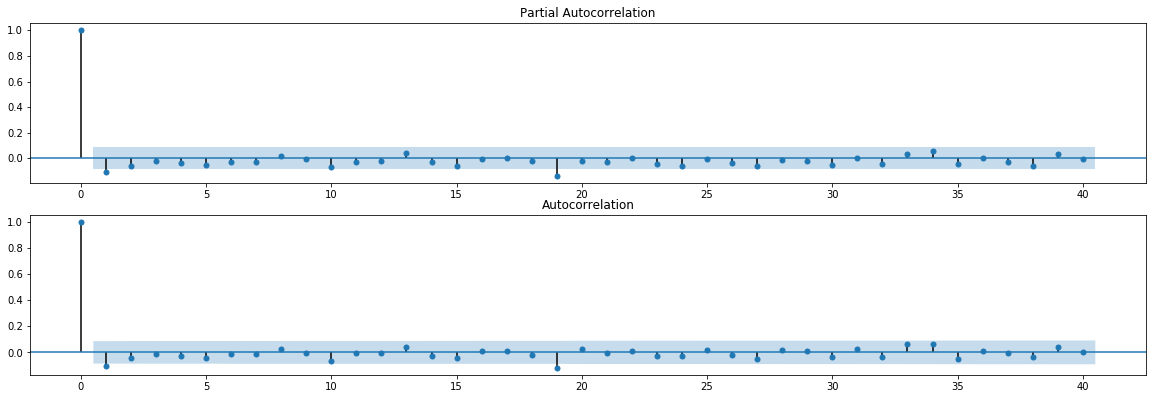

In [9]:
# Визуально оценим коррелограммы
model.show_autocorr()

In [10]:
# Подберем наилучшие параметры p,d,q для модели arima на основе информационного критерия Акаике
best_params = model.gen_arima_pdq(1)
best_params

(1, 1, 1)

R^2: 0.5311373361260261; RMSE: 0.6252616715798974; MAE: 0.4285895826309823


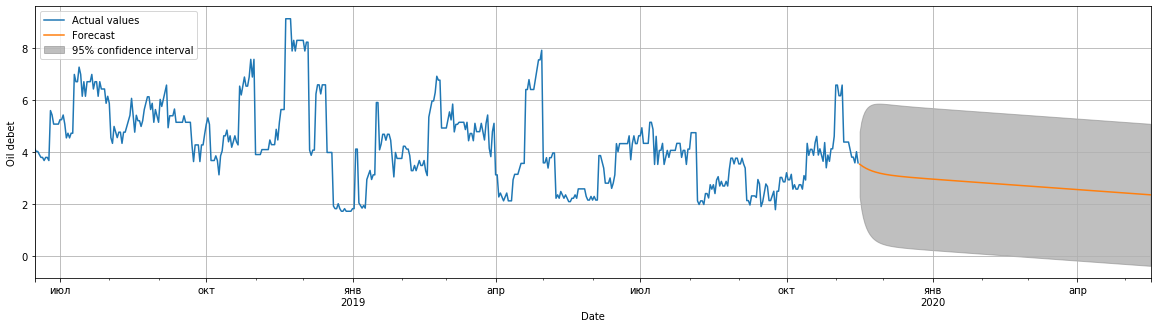

In [11]:
# Делаем предсказание на основе выбранных параметров
model.predict_manual_arima(best_params)

R^2: -0.016874375442287537; RMSE: 0.9208155267758353; MAE: 0.6160790074440545


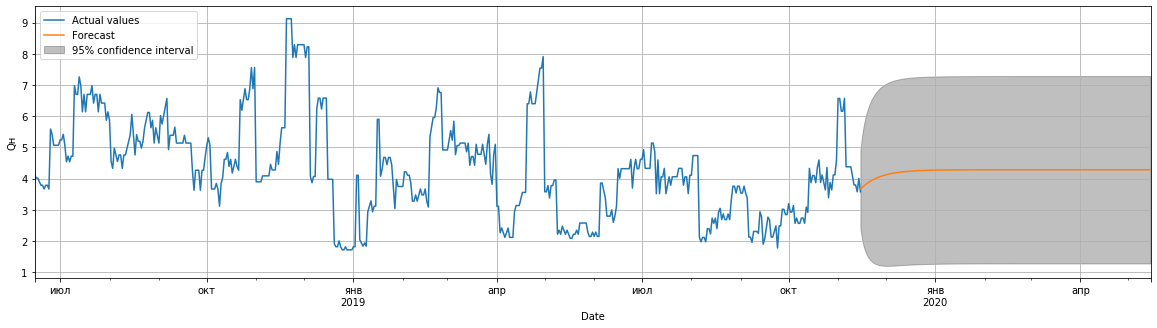

In [12]:
# Делаем предсказание аналогичной моделью, с автоматическим подбором параметров (библиотека pmdarima)
x = model.predict_auto_arima()

In [13]:
# Подберем наилучшие параметры p,d,q,P,D,Q,m для модели sarimax на основе информационного критерия Акаике
best_params = model.get_sarimax_pdq(1)
best_params

((1, 1, 1), (1, 1, 1, 4))

R^2: -0.36029899528628007; RMSE: 0.9515801039163224; MAE: 0.6699248014193538


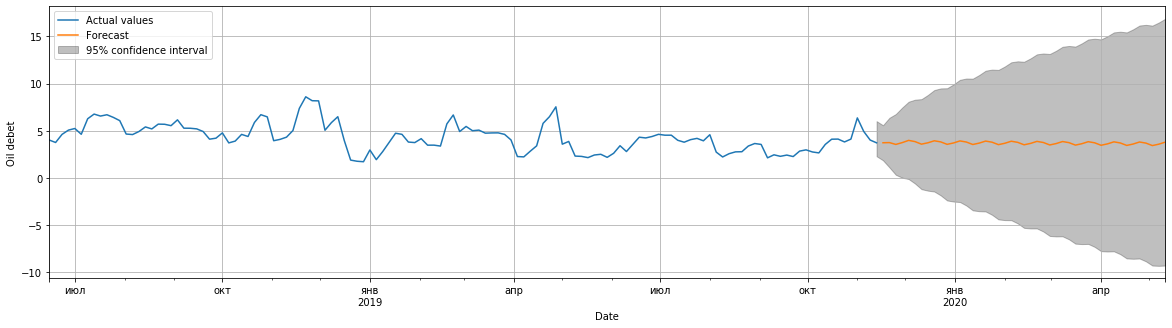

In [14]:
# Делаем предсказание на основе выбранных параметров
model.predict_manual_sarimax(best_params)

In [15]:
# Соберем полную таблицу параметров, имеющихся в исходном файле
def get_item(key):
    col = item.collect_timeseries(key)
    col = item.apply_idx(col)
    col = item.fill_nulls(col)
    return col

df = pd.DataFrame({key: get_item(key) for key in item.important_columns})

for key in df.keys():
    l = [i for i in df[key] if type(i) not in [int, float]]
    for _ in l:
        df = df.replace(_, None)

df = df.astype('float64')

df.head()

,F вращ ТМ,Qж(тн),Qн,Обв,Qж,Обв ХАЛ,Qж ТМ,Qж ТМ (исх)
2015-08-01,9.0,138.04,0.0,0.0,0.0,95.1,136.0,136.0
2015-08-02,9.0,138.04,0.0,0.0,0.0,95.1,136.0,136.0
2015-08-03,9.0,138.04,0.0,0.0,0.0,95.1,136.0,136.0
2015-08-04,9.0,138.04,0.0,0.0,0.0,95.1,136.0,136.0
2015-08-05,9.0,138.04,0.0,0.0,0.0,95.1,136.0,136.0


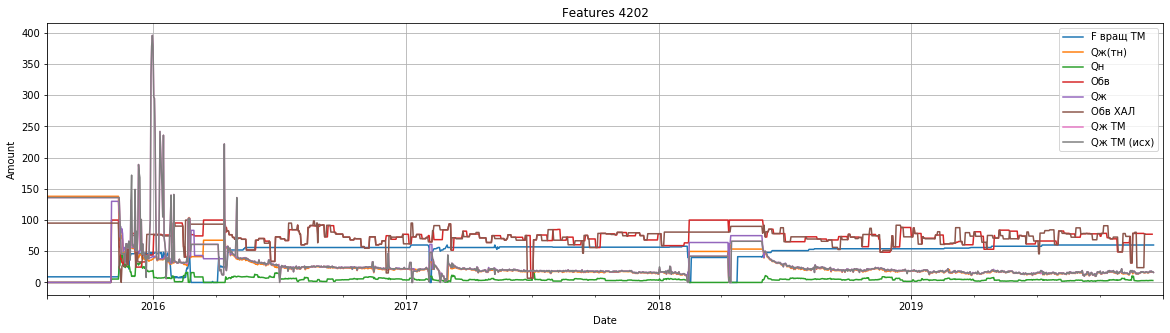

In [16]:
# Выведем на экран график всех параметров
item.show_plot(df)

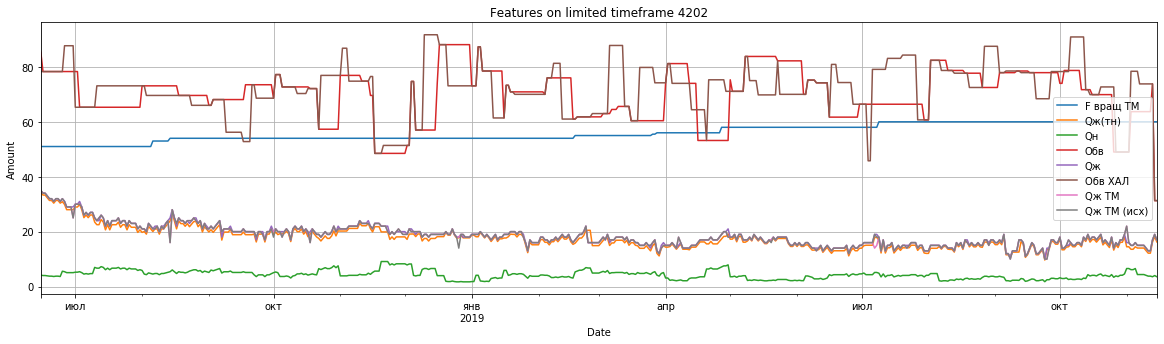

In [17]:
# Задаем временной интервал на основе выбранных ранее границ
subtable = df[start:end]
item.show_plot(subtable, title='Features on limited timeframe')

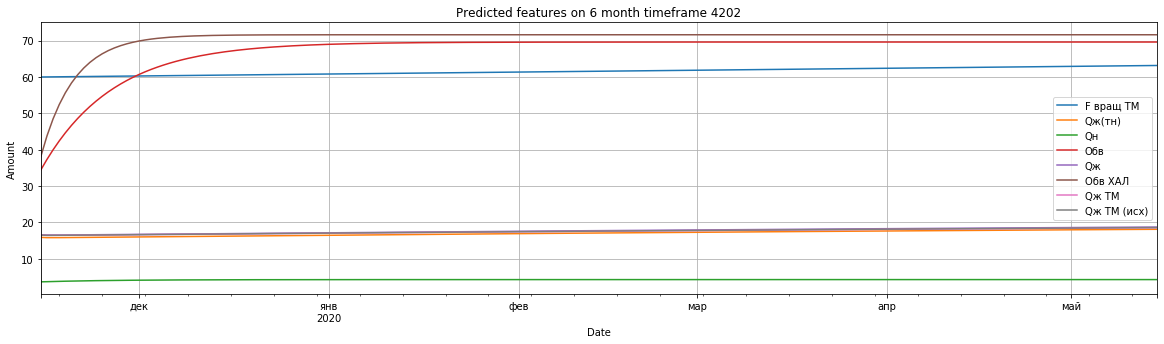

In [18]:
# Получаем предсказание модели autoarima для каждого из параметров
models_list = [StatModel(subtable[key]) for key in subtable.keys()]
auto_arima_forecast_df = pd.DataFrame(
    {model.subtable.name: model.predict_auto_arima(silent=True) for model in models_list}
)
item.show_plot(auto_arima_forecast_df, title='Predicted features on 6 month timeframe')

In [19]:
# Инициируем контейнер для обработки совокупности предсказанных ранее значений параметров
ml_model = MLModel(subtable, auto_arima_forecast_df)

# Разбиваем данные на тренировочную, тестовую и "предсказательную" выборки 
# (тренировочная используется для обучения модели, тестовая для ее проверки, а предсказательная для составления прогноза)
train_test_tuple = X_train, y_train, X_test, y_test, X_valid, y_valid = ml_model.split_table(test_size=32)

R^2: -0.9038422038632912; RMSE: 1.2599533249139518; MAE: 0.9928028920292855


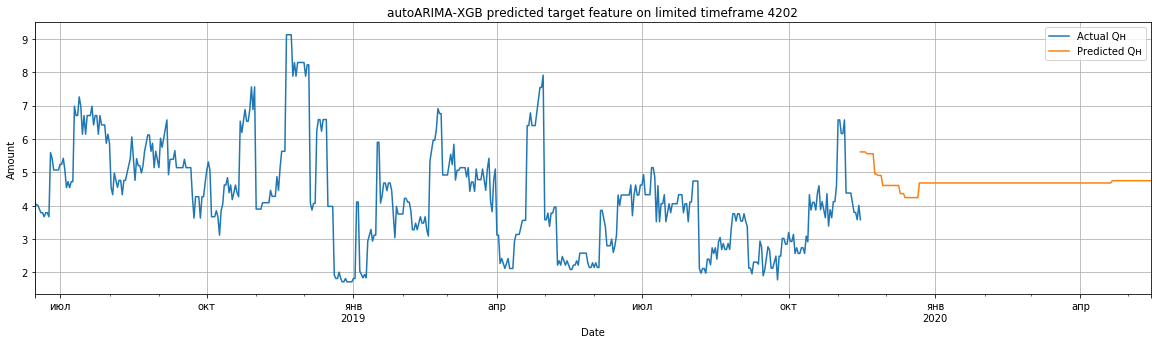

In [20]:
# Обучаем модель XGB
xgb = ml_model.xgb_model(X_train.append(X_test), y_train.append(y_test))

# Делаем предсказание и измеряем метрики
result_xgb = ml_model.get_prediction(xgb, train_test_tuple)

# Выводим на экран график предсказанного целевого параметра
item.show_plot(result_xgb, title='autoARIMA-XGB predicted target feature on limited timeframe')

R^2: -1.0685073894767179; RMSE: 1.313310814008211; MAE: 0.8633222851694718


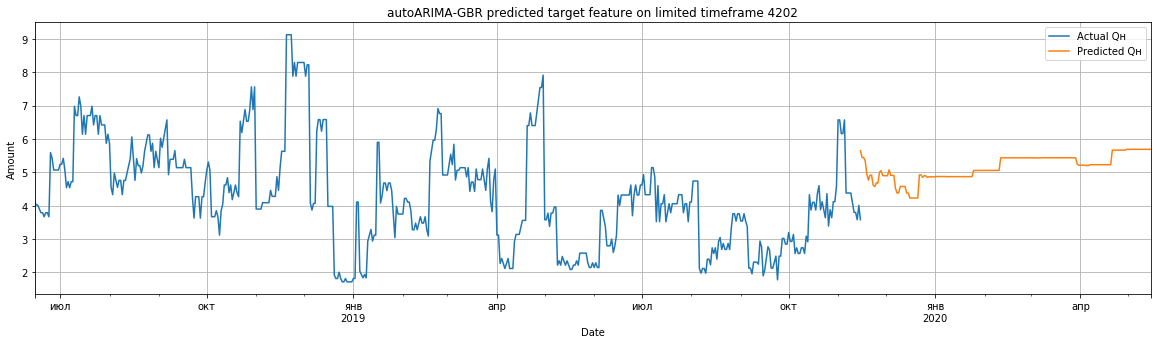

In [21]:
# Обучаем модель Gradient Boosting Regressor
gbr = ml_model.gbr_model(X_train, y_train)

# Делаем предсказание и измеряем метрики
result_gbr = ml_model.get_prediction(gbr, train_test_tuple)

# Выводим на экран график предсказанного целевого параметра
item.show_plot(result_gbr, title='autoARIMA-GBR predicted target feature on limited timeframe')

R^2: -0.9718078907756231; RMSE: 1.2822457908247717; MAE: 0.8599443516583105


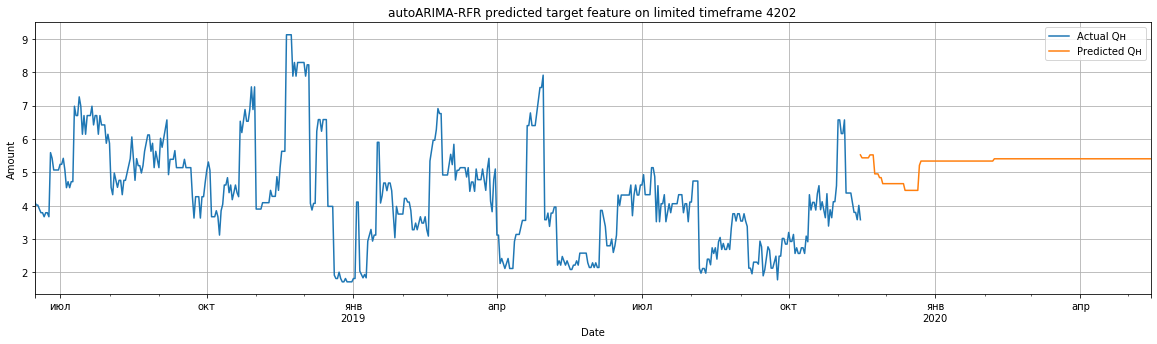

In [22]:
# Обучаем модель Random Forest Regressor
rfr = ml_model.rfr_model(X_train, y_train)

# Делаем предсказание и измеряем метрики
result_rfr = ml_model.get_prediction(rfr, train_test_tuple)

# Выводим на экран график предсказанного целевого параметра
item.show_plot(result_rfr, title='autoARIMA-RFR predicted target feature on limited timeframe')